# Homework set 10

## James Graham

In this problem we reproduce figure 9 from the paper "Globalization and Synchronization of Innovation Cycles" by Kiminori Matsuyama, Iryna Sushko, and Laura Gardini.

The paper presents a model of internationla innovation cycles, whereby firms decide when to innovate (and thus generate monopolistic rents) based on their expectations of their domestic and international competitors' behaviour. Depending on the parameterization of the model and the initial conditions of a given simulation, firms may end up in synchronized or asynchronized innovation cycles: i.e. firms either innovate together, or sequentially. 

Mathematically, the model features bifurcation points in the parameter space, such that for some setups the model features a steady state level of innovation towards which firms converge, while other setups feature endogenous cycles of innovation to which firms converge. The case considered here is such that there is a periodic 2-cycle: each period firms oscillate between innvoating and not innovating. When there are two countries of equal size, the parameterization also determines the size of the regions in which the evolution of the number of competitors in each country ($n_{1,t},n_{2,t}$) converges to a synchronized cycle.

Because the equations are tedious, I won't write them out again here, but begin the code in Python below. First, import the libraries we will need. 

In [47]:
import numpy as np
from scipy.optimize import bisect
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from numpy.linalg import norm

Now set the parameters, and define the h function. Note that we will solve everything on a 1000 point grid. 

In [48]:
# Set parameters
theta = 2.5
delta = 0.7
# rho   = 0.2

# Set evenly space grid points
Npoints = 1000

Now we create two functions. The first solves for the h function. The second function finds values for the h function on a grid, and then uses a spline (of user defined order; I use cubic splines) to approximate the function. The returned function, ``h_spline``, can then be used for interpolation at any point. Note that both of these functions depend on rho, which is important since we will vary rho later on. 

In [49]:
# Create the h function, which depends on rho
def h_fun(n, rho):
    def g_fun(h):
        g = 2 - 1/(h + rho*n) - 1/(h + n/rho)
        return g
    h = bisect(g_fun, 0, 1)
    return h

# Solve the h function on the grid
def h_spline(Npoints, rho, order):
    n_grid = np.linspace(1e-10,1,Npoints)
    h_grid = np.empty([Npoints,1])
    for n in range(Npoints):
        h_grid[n] = h_fun(n_grid[n],rho)
    h_spl = UnivariateSpline(n_grid, h_grid,k=order)
    return h_spl

As a check, I plot the approximation of the h function versus the true h function (on the grid) to show that the cubic spline is a good fit over the unit interval for rho=0.2. (It's also a good fit for the other values of rho, but I don't show that here). 

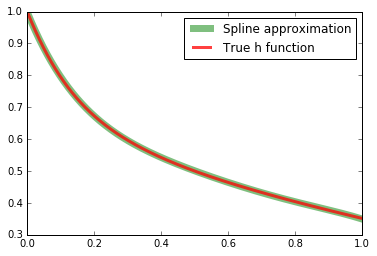

In [50]:
rho_test = 0.2
h_spl = h_spline(Npoints, rho_test, 5)

h_grid = np.empty([Npoints,1])
n_grid = np.linspace(1e-10,1,Npoints)
for n in range(Npoints):
    h_grid[n] = h_fun(n_grid[n],rho_test)
# Plot the approximation
%matplotlib inline
plt.plot(n_grid, h_spl(n_grid), 'g', lw=7, alpha=0.5,label='Spline approximation')
plt.plot(n_grid, h_grid, 'r', lw=3, alpha=0.75,label='True h function')
plt.legend()
plt.show()

Next, I define a law of motion function to compute the evolution of the number of competitors in each country. Then, I define a function to check for convergence of a simulation of a $\{n_{1,t},n_{2,t}\}$ sequence. Note, because the values follow a 2 period cycle, we cannot check consecutive values. Rather, we need to check convergence across values that are two periods apart i.e. at $t=1$ and $t=3$. Finally, define a simulation function which takes any initial values for $n_1,n_2$ and iterates until a user defined convergence tolerance is met. 

In [51]:
def law_motion(n1, n2, h_spl):    
    if n1 <= 0.5 and n2 <= 0.5:
        n1_next = delta*(theta/2 + (1-theta)*n1)
        n2_next = delta*(theta/2 + (1-theta)*n2)
    elif n1 >= h_spl(n2) and n2 >= h_spl(n1):
        n1_next = delta*n1
        n2_next = delta*n2
    elif n1 >= 0.5 and n2 <= h_spl(n1):
        n1_next = delta*n1
        n2_next = delta*(theta*h_spl(n1) + (1-theta)*n2)
    elif n1 <= h_spl(n2) and n2 >= 0.5:
        n1_next = delta*(theta*h_spl(n2) + (1-theta)*n1)        
        n2_next = delta*n2
    return n1_next, n2_next

def check_conv(n1_first, n2_first, n1_third, n2_third):
    first = np.array([n1_first, n2_first])     
    third = np.array([n1_third, n2_third])
    if norm(first - third) < 1e-4:
        conv = 1
    else:
        conv = 0
    return conv

Next I define a simulation function which will take a particular approximated h function, ``h_spl``, initial points for n1 and n2, and simulates for the number of periods given in N_iter. 

In [53]:
def simulation(N_iter, n1_init, n2_init, rho, tol):
    
    # Define spline approximation
    h_spl = h_spline(Npoints, rho, 5)
    
    # Run simulation
    n1 = np.empty([N_iter,1])
    n2 = np.empty([N_iter,1])
    n1[0] = n1_init
    n2[0] = n2_init
    for t in range(1,N_iter):
        n1[t], n2[t] = law_motion(n1[t-1],n2[t-1], h_spl)
        
        # check for convergence
        if t >= 2:
            check = check_conv(n1[t], n2[t], n1[t-2], n2[t-2])
            if norm(check) == 1:
                break
        
    # Trim sample
    n1 = n1[0:t]
    n2 = n2[0:t]     
        
    # Check synchronization
    if np.isclose(n1[t-1],n2[t-1], tol):
        sync = 1
    else:
        sync = 0

    return n1, n2, sync

Below I test the simulation function for rho=0.8, and with the initial points $(0.2,0.5)$. We can see that the series begin out of sync, but become synchronized after around 10 periods. 

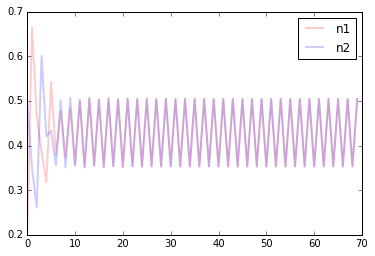

In [54]:
rho_test = 0.6
n1, n2, sync = simulation(500, 0.2, 0.5, rho_test, 1e-5)

plt.plot(n1, 'r', lw=2,label='n1', alpha = 0.2)
plt.plot(n2, 'b', lw=2,label='n2', alpha = 0.2)
plt.legend()
plt.show()

Now we need to run simulations that start from many points in the unit square. To do this, I define a 100 by 100 point grid in the unit square, run the simulation starting from each point in the grid, and collect information on whether that starting point leads to synchronization or asynchronization. 

In [63]:
# Run across all grid points 
Npoints = 50
N_iter = 100
n_grid = np.linspace(1e-10,1,Npoints)


Finally, we can plot the synchronization/asynchronization regions for each value of $rho = [0.2,0.4,0.6,0.8]$. I use a fairly coarse grid (only 50 grid points), since the code is somewhat slow. 

The red shapes represent regions in which initial conditions lead to convergence to synchronized cycles. The white shapes represent regions in which initial conditions lead to convergence to asynchronized cycles.

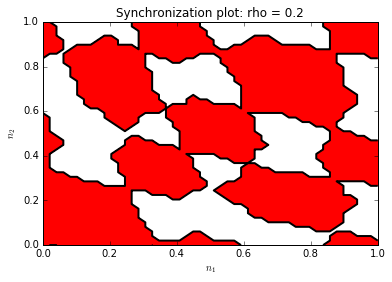

In [64]:
rho = 0.2
sync = np.empty(([Npoints,Npoints]))
for nn in range(Npoints):
    for mm in range(Npoints):  
        n1, n2, sync[nn,mm] = simulation(N_iter, n_grid[nn], n_grid[mm], rho, 1e-4)

levels = [0.01, 1]      # Helps divide the contour colours nicely
c = plt.contour(n_grid, n_grid, sync, levels, linewidths=2, colors='k')
colorscheme = ('r','w') 
c = plt.contourf(n_grid, n_grid, sync, levels, colors=colorscheme) 
plt.xlabel("$n_1$")
plt.ylabel("$n_2$")
plt.title("Synchronization plot: rho = 0.2")
plt.show()

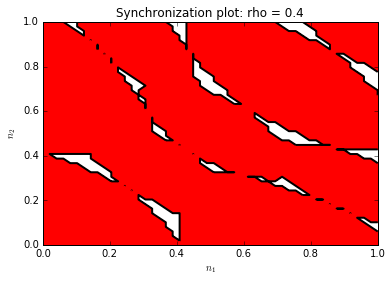

In [65]:
rho = 0.4
sync = np.empty(([Npoints,Npoints]))
for nn in range(Npoints):
    for mm in range(Npoints):  
        n1, n2, sync[nn,mm] = simulation(N_iter, n_grid[nn], n_grid[mm], rho, 1e-4)

levels = [0.01, 1]      # Helps divide the contour colours nicely
c = plt.contour(n_grid, n_grid, sync, levels, linewidths=2, colors='k')
colorscheme = ('r','w') 
c = plt.contourf(n_grid, n_grid, sync, levels, colors=colorscheme) 
plt.xlabel("$n_1$")
plt.ylabel("$n_2$")
plt.title("Synchronization plot: rho = 0.4")
plt.show()

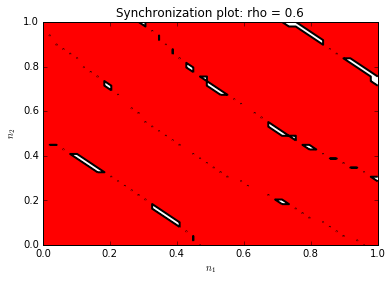

In [66]:
rho = 0.6
sync = np.empty(([Npoints,Npoints]))
for nn in range(Npoints):
    for mm in range(Npoints):  
        n1, n2, sync[nn,mm] = simulation(N_iter, n_grid[nn], n_grid[mm], rho, 1e-4)

levels = [0.01, 1]      # Helps divide the contour colours nicely
c = plt.contour(n_grid, n_grid, sync, levels, linewidths=2, colors='k')
colorscheme = ('r','w') 
c = plt.contourf(n_grid, n_grid, sync, levels, colors=colorscheme) 
plt.xlabel("$n_1$")
plt.ylabel("$n_2$")
plt.title("Synchronization plot: rho = 0.6")
plt.show()

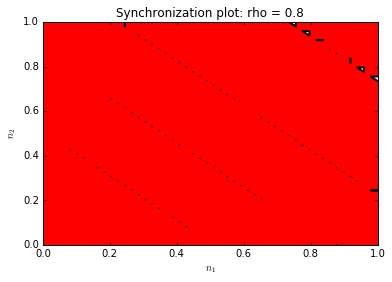

In [67]:
rho = 0.8
sync = np.empty(([Npoints,Npoints]))
for nn in range(Npoints):
    for mm in range(Npoints):  
        n1, n2, sync[nn,mm] = simulation(N_iter, n_grid[nn], n_grid[mm], rho, 1e-4)

levels = [0.01, 1]      # Helps divide the contour colours nicely
c = plt.contour(n_grid, n_grid, sync, levels, linewidths=2, colors='k')
colorscheme = ('r','w') 
c = plt.contourf(n_grid, n_grid, sync, levels, colors=colorscheme) 
plt.xlabel("$n_1$")
plt.ylabel("$n_2$")
plt.title("Synchronization plot: rho = 0.8")
plt.show()

As we can see, all four plots match (although with more coarseness than they have) the features of figure 9.a) in the paper. 